# Sparkify - EDA, Cleaning, & Feature Engineering

This notebook uses a small subset (128MB) of the full dataset available (12GB). I'll initially explore, clean, feature engineer, and split the data subset. I'll then use the train/test sample data to test out my modeling pipelines. Once ready, I'll be leverage Azure Databricks to run my pipelines at scale. 

In [1]:
# import libraries
from pyspark.sql import SparkSession
import sys
sys.path.append("../src")
from sparkifychurn import cleanData, exploreData, generateFeatures, utils
from pyspark import SparkConf
import pyspark.sql.functions as F
import pandas as pd
pd.set_option("max.columns", None)
pd.set_option("max.rows", None)
import seaborn as sns
from sklearn import metrics
import plotly.express as px
from matplotlib import pyplot as plt
sns.set_theme()

## Set-up Spark Session
Here, I'll just be using the default configuration on my local machine to do some initial data exploration and prototyping. The nice thing about doing things this way is that it is really easy to get started. There are no other installs needed except for using `pip install pyspark`. You can read more info about this [here](https://spark.apache.org/docs/latest/api/python/getting_started/install.html).

In [2]:
spark = SparkSession\
        .builder\
        .appName("Sparkify")\
        .config("spark.ui.showConsoleProgress", False)\
        .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/24 19:50:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

# Load and Clean Dataset
First, I'll load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Try to read file locally, if not available, read from S3
try:
    df = spark.read.json("../data/mini_sparkify_event_data.json").cache()
except:
    df = spark.read.json("s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json").cache()

In [5]:
df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [6]:
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [7]:
(df.count(),len(df.columns))

(286500, 18)

Next, I wrote a custom function to summarize missing values in a spark dataframe.

In [8]:
missing_summary = exploreData.summarize_missing_vals(df)

****Feature artist complete.****
****Feature auth complete.****
****Feature firstName complete.****
****Feature gender complete.****
****Feature itemInSession complete.****
****Feature lastName complete.****
****Feature length complete.****
****Feature level complete.****
****Feature location complete.****
****Feature method complete.****
****Feature page complete.****
****Feature registration complete.****
****Feature sessionId complete.****
****Feature song complete.****
****Feature status complete.****
****Feature ts complete.****
****Feature userAgent complete.****
****Feature userId complete.****


In [9]:
missing_summary

,feature,data_type,missing_count,missing_percentage,empty_string_count,empty_percentage
0,artist,string,58392,20.38,0.0,0.00
1,auth,string,0,0.00,0.0,0.00
2,firstName,string,8346,2.91,0.0,0.00
3,gender,string,8346,2.91,0.0,0.00
4,itemInSession,bigint,0,0.00,NaN,NaN
5,lastName,string,8346,2.91,0.0,0.00
6,length,double,58392,20.38,NaN,NaN
7,level,string,0,0.00,0.0,0.00
8,location,string,8346,2.91,0.0,0.00
9,method,string,0,0.00,0.0,0.00


In [10]:
df.groupby("auth").count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
| Logged In|278102|
|     Guest|    97|
+----------+------+



In [11]:
df.filter(F.col("auth")=="Guest").limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Guest,None,None,0,None,NaN,free,None,GET,Error,NaN,151,None,404,1540841775000,None,
1,None,Guest,None,None,1,None,NaN,free,None,GET,Home,NaN,151,None,200,1540841817000,None,
2,None,Guest,None,None,2,None,NaN,free,None,GET,Register,NaN,151,None,200,1540841826000,None,
3,None,Guest,None,None,3,None,NaN,free,None,GET,Help,NaN,151,None,200,1540841834000,None,
4,None,Guest,None,None,4,None,NaN,free,None,GET,Home,NaN,151,None,200,1540841838000,None,


I noticed that there are a few minor things that need to be done to clean the data. I'll convert the `ts` timestamp to human-readable and remove missing/null `userId`s. 

In [12]:
clean_df = cleanData.clean_logs(df)

In [13]:
clean_df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [14]:
clean_df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [15]:
exploreData.summarize_missing_vals(clean_df)

****Feature artist complete.****
****Feature auth complete.****
****Feature firstName complete.****
****Feature gender complete.****
****Feature itemInSession complete.****
****Feature lastName complete.****
****Feature length complete.****
****Feature level complete.****
****Feature location complete.****
****Feature method complete.****
****Feature page complete.****
****Feature registration complete.****
****Feature sessionId complete.****
****Feature song complete.****
****Feature status complete.****
****Feature ts complete.****
****Feature userAgent complete.****
****Feature userId complete.****


,feature,data_type,missing_count,missing_percentage,empty_string_count,empty_percentage
0,artist,string,50046,17.99,0.0,0.0
1,auth,string,0,0.00,0.0,0.0
2,firstName,string,0,0.00,0.0,0.0
3,gender,string,0,0.00,0.0,0.0
4,itemInSession,bigint,0,0.00,NaN,NaN
5,lastName,string,0,0.00,0.0,0.0
6,length,double,50046,17.99,NaN,NaN
7,level,string,0,0.00,0.0,0.0
8,location,string,0,0.00,0.0,0.0
9,method,string,0,0.00,0.0,0.0


The the remaining null values are a result of interactions in the logs that are non-song related. 

# Initial Exploratory Data Analysis

In [16]:
clean_df.groupby("auth").count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



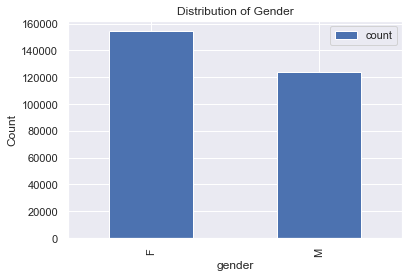

In [17]:
clean_df.groupby("gender").count().toPandas().plot(x="gender", y = "count", kind="bar")
plt.ylabel("Count")
plt.title("Distribution of Gender");

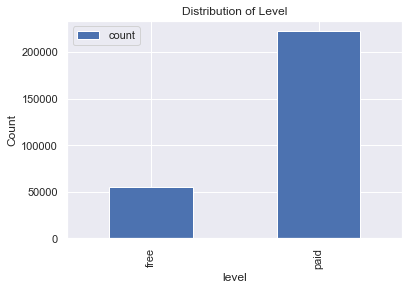

In [18]:
clean_df.groupby("level").count().toPandas().plot(x="level", y = "count", kind="bar")
plt.ylabel("Count")
plt.title("Distribution of Level");

In [19]:
clean_df.select("location").drop_duplicates().show()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Kingsport-Bristol...|
|New Haven-Milford...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
|Allentown-Bethleh...|
|Miami-Fort Lauder...|
|           Selma, AL|
+--------------------+
only showing top 20 rows



Check out a single user's usage patterns and resulting subscription cancellation:

In [20]:
clean_df.filter(F.col("userId")==18).sort("ts", ascending = True).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Adriel,M,0,Mendoza,NaN,paid,"Kansas City, MO-KS",GET,Home,1535623466000,242,None,200,1538499917,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
1,Mike And The Mechanics,Logged In,Adriel,M,1,Mendoza,275.12118,paid,"Kansas City, MO-KS",PUT,NextSong,1535623466000,242,A Beggar On A Beach Of Gold,200,1538499933,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
2,Taking Back Sunday,Logged In,Adriel,M,2,Mendoza,268.32934,paid,"Kansas City, MO-KS",PUT,NextSong,1535623466000,242,...slowdance On The Inside (Album Version),200,1538500208,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
3,Beirut,Logged In,Adriel,M,3,Mendoza,178.72934,paid,"Kansas City, MO-KS",PUT,NextSong,1535623466000,242,St. Apollonia,200,1538500476,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
4,Bob Log III,Logged In,Adriel,M,4,Mendoza,188.76036,paid,"Kansas City, MO-KS",PUT,NextSong,1535623466000,242,Drunk Stripper,200,1538500654,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
5,Krisiun,Logged In,Adriel,M,5,Mendoza,167.91465,paid,"Kansas City, MO-KS",PUT,NextSong,1535623466000,242,In League With Satan,200,1538500842,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
6,None,Logged In,Adriel,M,6,Mendoza,NaN,paid,"Kansas City, MO-KS",GET,Settings,1535623466000,242,None,200,1538500856,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
7,HYPOCRISY,Logged In,Adriel,M,7,Mendoza,331.38893,paid,"Kansas City, MO-KS",PUT,NextSong,1535623466000,242,The Quest,200,1538501009,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
8,Bullet For My Valentine,Logged In,Adriel,M,8,Mendoza,247.69261,paid,"Kansas City, MO-KS",PUT,NextSong,1535623466000,242,Waking The Demon,200,1538501340,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
9,She & Him,Logged In,Adriel,M,9,Mendoza,153.52118,paid,"Kansas City, MO-KS",PUT,NextSong,1535623466000,242,Why Do You Let Me Stay Here?,200,1538501587,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18


In [21]:
user_count = df.select("userId").drop_duplicates().count()
print("Number of unique users: {}".format(user_count))

Number of unique users: 226


Let's take a look at another customer and sort their interactions from first to last:

In [22]:
clean_df.filter(F.col("userId")==30).sort("ts", ascending = True).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
2,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
4,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
6,Edward Sharpe & The Magnetic Zeros,Logged In,Colin,M,56,Freeman,223.58159,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Jade,200,1538353218,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
7,Stan Mosley,Logged In,Colin,M,57,Freeman,246.69995,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,So-Called Friends,200,1538353441,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,Orishas,Logged In,Colin,M,58,Freeman,222.22322,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Represent,200,1538353687,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Downhere,Logged In,Colin,M,59,Freeman,223.92118,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Here I Am,200,1538353909,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [23]:
page_summary = clean_df.groupby("page").count().sort("count", ascending = False).toPandas()

In [24]:
page_summary.sort_values("count", ascending = False)

,page,count
0,NextSong,228108
1,Thumbs Up,12551
2,Home,10082
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Logout,3226
7,Thumbs Down,2546
8,Downgrade,2055
9,Settings,1514


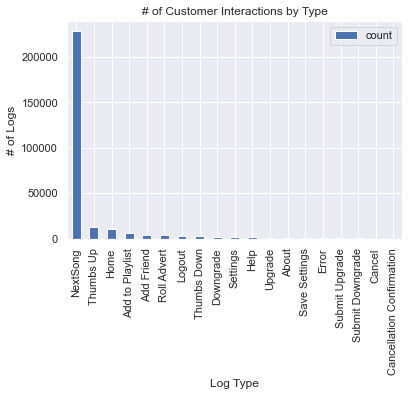

In [25]:
from matplotlib import pyplot as plt
page_summary.plot.bar(x="page", y = "count")
plt.xlabel("Log Type")
plt.ylabel("# of Logs")
plt.title("# of Customer Interactions by Type");

In [26]:
clean_df.groupby("method", "status").count().show()

+------+------+------+
|method|status| count|
+------+------+------+
|   PUT|   200|234634|
|   GET|   200| 20084|
|   PUT|   307| 23184|
|   GET|   404|   252|
+------+------+------+



In [27]:
clean_df.filter(F.col("status")=="307").limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Micah,M,86,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1538331630000,8,None,307,1538353376,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
1,None,Logged In,Alexi,F,7,Warren,NaN,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1532482662000,53,None,307,1538355255,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
2,None,Logged In,Micah,M,95,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Down,1538331630000,8,None,307,1538355306,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
3,None,Logged In,Micah,M,99,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Logout,1538331630000,8,None,307,1538355687,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,None,Logged In,Ashlynn,F,9,Williams,NaN,free,"Tallahassee, FL",PUT,Thumbs Up,1537365219000,217,None,307,1538355711,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",74


In [28]:
clean_df.groupby("status", "method", "page").count().show()

+------+------+--------------------+------+
|status|method|                page| count|
+------+------+--------------------+------+
|   404|   GET|               Error|   252|
|   200|   GET|               About|   495|
|   307|   PUT|    Submit Downgrade|    63|
|   200|   GET|             Upgrade|   499|
|   200|   GET|           Downgrade|  2055|
|   200|   GET|Cancellation Conf...|    52|
|   200|   PUT|            NextSong|228108|
|   307|   PUT|              Cancel|    52|
|   307|   PUT|          Add Friend|  4277|
|   307|   PUT|              Logout|  3226|
|   200|   GET|                Home| 10082|
|   200|   GET|         Roll Advert|  3933|
|   200|   GET|            Settings|  1514|
|   200|   GET|                Help|  1454|
|   200|   PUT|     Add to Playlist|  6526|
|   307|   PUT|           Thumbs Up| 12551|
|   307|   PUT|       Save Settings|   310|
|   307|   PUT|         Thumbs Down|  2546|
|   307|   PUT|      Submit Upgrade|   159|
+------+------+-----------------

## Feature Engineering
My general approach is to summarize individual user behavior such that it is a single observation in the final data set and use their behavior to identify characteristics of service cancellation (for both free and paid tiers). One of the main features in the log data is the "page" feature. This describes various interactions the user is having during their engagement with the service. We'll look at the various interaction types, how often they occur, and their "rate" of occurence relative to their total engagement time with the platform.

### Define Churn
My target column is based on if a user has a `page` = "Cancellation Confirmation" event, which indicates cancellation of a users subscription, regardless of if they are using the free or paid version.

In [29]:
user_summary = generateFeatures.generate_features(clean_df)

In [30]:
user_summary.limit(5).toPandas()

22/01/24 19:51:29 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,userId,gender,count_items,sum_length,paid,session_count,submit_downgrade_count,thumbs_down_count,home_count,downgrade_count,advert_count,save_settings_count,churn,about_count,settings_count,add_playlist_count,add_friend_count,next_song_count,thumbs_up_count,help_count,upgrade_count,error_count,submit_upgrade,non_song_interaction_count,PUT_200_count,GET_200_count,PUT_307_count,tenure_days,thumbs_up_pct,avg_items_session,avg_songs_session,sum_session_length_hours,avg_session_length_hours,interaction_rate,submit_downgrade_rate,thumbs_down_rate,home_rate,downgrade_rate,advert_rate,save_settings_rate,about_rate,settings_rate,add_playlist_rate,add_friend_rate,next_song_rate,thumbs_up_rate,help_rate,upgrade_rate,error_rate,non_song_interaction_rate
0,10,M,795,166866.37251,1,6,0,4,30,7,1,1,0,2,7,9,12,673,37,1,0,0,0,122,682,48,65,42.437130,0.902439,132.500000,112.166667,45.974722,7.662454,17.292111,0.000000,0.087004,0.652532,0.152258,0.021751,0.021751,0.043502,0.152258,0.195760,0.261013,14.638479,0.804790,0.021751,0.000000,0.000000,2.653632
1,100,M,3214,672877.85659,1,35,1,27,105,30,25,5,0,12,11,61,49,2682,148,18,1,3,1,532,2743,202,266,58.966285,0.845714,91.828571,76.628571,184.636111,5.275317,17.407212,0.005416,0.146234,0.568686,0.162482,0.135401,0.027080,0.064993,0.059577,0.330380,0.265387,14.525869,0.801577,0.097489,0.005416,0.016248,2.881343
2,100001,F,187,35073.74215,0,4,0,2,11,0,14,0,1,0,1,3,2,133,8,1,2,1,0,53,136,30,20,1.408576,0.800000,46.750000,33.250000,9.877222,2.469306,18.932448,0.000000,0.202486,1.113673,0.000000,1.417403,0.000000,0.000000,0.101243,0.303729,0.202486,13.465324,0.809944,0.101243,0.202486,0.101243,5.365881
3,100002,F,218,49559.91810,1,4,0,0,6,2,3,0,0,0,0,5,1,195,5,0,0,0,0,23,200,11,7,55.092951,1.000000,54.500000,48.750000,13.412222,3.353056,16.253831,0.000000,0.000000,0.447353,0.149118,0.223677,0.000000,0.000000,0.000000,0.372794,0.074559,14.538978,0.372794,0.000000,0.000000,0.000000,1.714854
4,100003,F,78,12306.41932,0,2,0,0,7,0,9,0,1,0,0,2,0,51,3,1,0,0,0,26,53,18,7,2.018067,1.000000,39.000000,25.500000,3.303889,1.651944,23.608542,0.000000,0.000000,2.118715,0.000000,2.724063,0.000000,0.000000,0.000000,0.605347,0.000000,15.436354,0.908021,0.302674,0.000000,0.000000,7.869514


In [ ]:
exploreData.summarize_missing_vals()

In [31]:
exploreData.summarize_missing_vals(user_summary)

****Feature userId complete.****
****Feature gender complete.****
****Feature count_items complete.****
****Feature sum_length complete.****
****Feature paid complete.****
****Feature session_count complete.****
****Feature submit_downgrade_count complete.****
****Feature thumbs_down_count complete.****
****Feature home_count complete.****
****Feature downgrade_count complete.****
****Feature advert_count complete.****
****Feature save_settings_count complete.****
****Feature churn complete.****
****Feature about_count complete.****
****Feature settings_count complete.****
****Feature add_playlist_count complete.****
****Feature add_friend_count complete.****
****Feature next_song_count complete.****
****Feature thumbs_up_count complete.****
****Feature help_count complete.****
****Feature upgrade_count complete.****
****Feature error_count complete.****
****Feature submit_upgrade complete.****
****Feature non_song_interaction_count complete.****
****Feature PUT_200_count complete.****

,feature,data_type,missing_count,missing_percentage,empty_string_count,empty_percentage
0,userId,string,0,0.0,0.0,0.0
1,gender,string,0,0.0,0.0,0.0
2,count_items,bigint,0,0.0,NaN,NaN
3,sum_length,double,0,0.0,NaN,NaN
4,paid,int,0,0.0,NaN,NaN
5,session_count,bigint,0,0.0,NaN,NaN
6,submit_downgrade_count,bigint,0,0.0,NaN,NaN
7,thumbs_down_count,bigint,0,0.0,NaN,NaN
8,home_count,bigint,0,0.0,NaN,NaN
9,downgrade_count,bigint,0,0.0,NaN,NaN


# Exploratory Data Analysis
Next we'll explore summary statistics, with a focus on how those summary statistics break down along the target column. 

In [32]:
user_summary.groupby("churn").agg(F.mean("sum_length"), 
                                  F.mean("count_items"),
                                  F.mean("thumbs_down_count"), 
                                  F.mean("thumbs_down_rate"), 
                                  F.mean("interaction_rate"), 
                                  F.mean("avg_session_length_hours"),
                                  F.mean("thumbs_up_pct"),
                                  F.mean("tenure_days"),
                                  F.mean("error_rate"), 
                                  F.mean("advert_rate"),
                                  F.mean("submit_downgrade_rate"), 
                                  F.mean("avg_items_session"), 
                                  F.mean("settings_rate"), 
                                  F.mean("non_song_interaction_rate")).toPandas()

,churn,avg(sum_length),avg(count_items),avg(thumbs_down_count),avg(thumbs_down_rate),avg(interaction_rate),avg(avg_session_length_hours),avg(thumbs_up_pct),avg(tenure_days),avg(error_rate),avg(advert_rate),avg(submit_downgrade_rate),avg(count_items),avg(avg_items_session),avg(settings_rate),avg(non_song_interaction_rate)
0,1,174014.268551,862.769231,9.538462,0.257891,19.197636,4.326242,0.738292,23.514648,0.013791,0.874167,0.003334,862.769231,77.617051,0.195609,4.503446
1,0,276166.937468,1348.497110,11.849711,0.148036,18.161430,4.946176,0.829565,46.990873,0.018385,0.538325,0.003719,1348.497110,86.995174,0.148272,3.671901


It's interesting to note that customers that churned had a lower average session time, higher thumbs down rate, lower thumbs up rate, higher advertisement rate, and shorter sessions.

In [33]:
user_summary.count()

225

In [34]:
user_summary_pd = user_summary.toPandas()

In [35]:
user_summary_pd.dtypes

userId                         object
gender                         object
count_items                     int64
sum_length                    float64
paid                            int32
session_count                   int64
submit_downgrade_count          int64
thumbs_down_count               int64
home_count                      int64
downgrade_count                 int64
advert_count                    int64
save_settings_count             int64
churn                           int32
about_count                     int64
settings_count                  int64
add_playlist_count              int64
add_friend_count                int64
next_song_count                 int64
thumbs_up_count                 int64
help_count                      int64
upgrade_count                   int64
error_count                     int64
submit_upgrade                  int32
non_song_interaction_count      int64
PUT_200_count                   int64
GET_200_count                   int64
PUT_307_coun

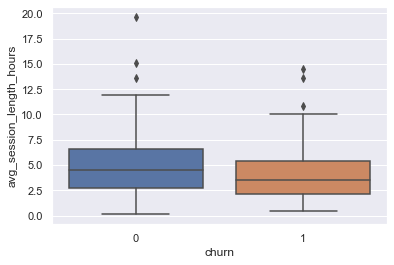

In [36]:
sns.boxplot(x = "churn", y = "avg_session_length_hours", data = user_summary_pd);

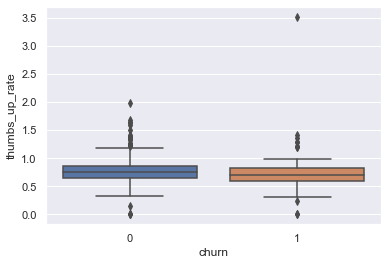

In [37]:
sns.boxplot(x = "churn", y = "thumbs_up_rate", data = user_summary_pd);

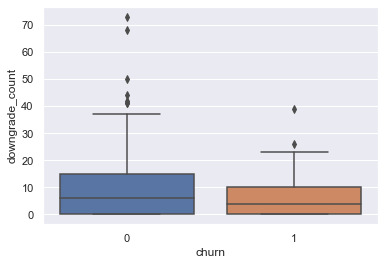

In [38]:
sns.boxplot(x = "churn", y = "downgrade_count", data = user_summary_pd);

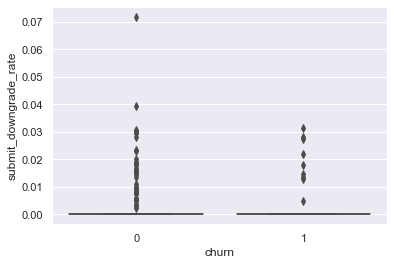

In [39]:
sns.boxplot(x = "churn", y = "submit_downgrade_rate", data = user_summary_pd);

In [40]:
user_summary_pd.groupby('churn').agg(['mean','std'])

userId                 count_items                  sum_length  \
                mean            std         mean          std           mean   
churn                                                                          
0                inf  110276.043767  1348.497110  1425.428637  276166.937468   
1      1.923098e+225   86381.677066   862.769231   852.262378  174014.268551   

                          paid           session_count             \
                 std      mean       std          mean        std   
churn                                                               
0      294900.238162  0.745665  0.436751     15.254335  15.866963   
1      177867.161274  0.692308  0.466041     10.326923   8.610803   

      submit_downgrade_count           thumbs_down_count             \
                        mean       std              mean        std   
churn                                                                 
0                   0.312139  0.634037         11.849711  14.035274   
1                   0.173077  0.382005          9.538462   9.088803   

      home_count            downgrade_count            advert_count  \
            mean        std            mean        std         mean   
churn                                                                 
0      48.612717  50.936181        9.930636  12.513520    17.144509   
1      32.153846  29.368106        6.480769   8.206861    18.596154   

                 save_settings_count           about_count            \
             std                mean       std        mean       std   
churn                                                                  
0      21.527077            1.456647  1.856674    2.537572  3.426136   
1      21.799676            1.115385  1.231193    1.076923  1.218262   

      settings_count           add_playlist_count            add_friend_count  \
                mean       std               mean        std             mean   
churn                                                                           
0           7.190751  7.481258          31.722543  35.056821        21.046243   
1           5.192308  4.723900          19.961538  21.166901        12.230769   

                 next_song_count              thumbs_up_count             \
             std            mean          std            mean        std   
churn                                                                      
0      22.286667     1108.173410  1183.146703       61.803468  70.416424   
1      11.157720      699.884615   714.737650       35.750000  39.697817   

      help_count           upgrade_count           error_count            \
            mean       std          mean       std        mean       std   
churn                                                                      
0       7.023121  7.664441      2.236994  2.655932    1.271676  1.585236   
1       4.596154  5.259015      2.153846  2.226266    0.615385  0.843751   

      submit_upgrade           non_song_interaction_count             \
                mean       std                       mean        std   
churn                                                                  
0           0.589595  0.493335                 240.323699  244.60376   
1           0.557692  0.501506                 161.884615  140.93896   

      PUT_200_count              GET_200_count            PUT_307_count  \
               mean          std          mean        std          mean   
churn                                                                     
0       1139.895954  1217.777632     94.676301  92.937647    112.653179   
1        719.846154   735.355040     71.250000  57.839153     71.057692   

                  tenure_days            thumbs_up_pct            \
              std        mean        std          mean       std   
churn                                                              
0      120.209633   46.990873  16.129928      0.829565  0.144283   
1       66.351829

<AxesSubplot:xlabel='churn', ylabel='advert_rate'>

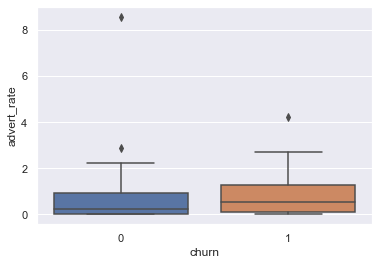

In [41]:
sns.boxplot(y = "advert_rate", x = "churn", data = user_summary_pd)

In [42]:
pd.crosstab(user_summary_pd["churn"], user_summary_pd["paid"], normalize = "columns")

paid,0,1
churn,,
0,0.733333,0.781818
1,0.266667,0.218182


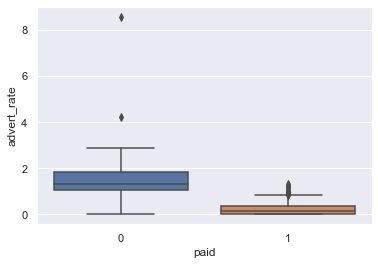

In [43]:
sns.boxplot(x = "paid", y = "advert_rate", data = user_summary_pd);

In [44]:
correlations=user_summary_pd.corr()

<AxesSubplot:>

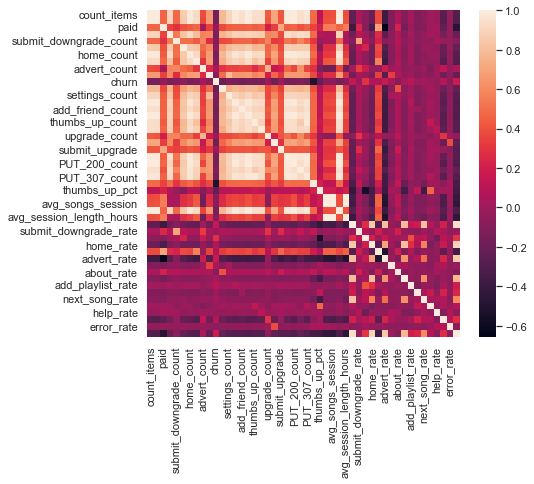

In [45]:
# Make the figsize 7 x 6
plt.figure(figsize=(7,6))
# Plot heatmap of correlations
sns.heatmap(correlations)

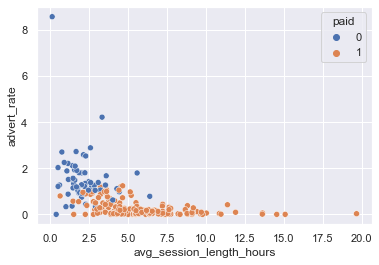

In [46]:
sns.scatterplot(x="avg_session_length_hours", y="advert_rate", hue="paid", data=user_summary_pd);

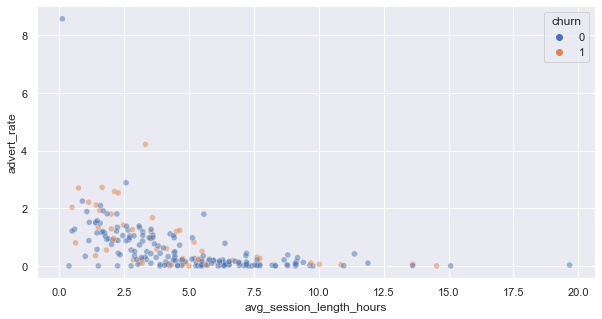

In [47]:
plt.figure(figsize=(10,5));
sns.scatterplot(x="avg_session_length_hours", y="advert_rate", hue="churn", alpha = .5, data=user_summary_pd);

# Split & Save Data

Next, I'll generate a train-test split stratified on the `churn` column so that my minority class (`churn`=1) is proportionally split between my training and test set. 

In [48]:
train, test = utils.train_test_stratified_split(user_summary, "churn", [.7, .3], 1234)

In [49]:
train.limit(5).toPandas()

,userId,gender,count_items,sum_length,paid,session_count,submit_downgrade_count,thumbs_down_count,home_count,downgrade_count,advert_count,save_settings_count,churn,about_count,settings_count,add_playlist_count,add_friend_count,next_song_count,thumbs_up_count,help_count,upgrade_count,error_count,submit_upgrade,non_song_interaction_count,PUT_200_count,GET_200_count,PUT_307_count,tenure_days,thumbs_up_pct,avg_items_session,avg_songs_session,sum_session_length_hours,avg_session_length_hours,interaction_rate,submit_downgrade_rate,thumbs_down_rate,home_rate,downgrade_rate,advert_rate,save_settings_rate,about_rate,settings_rate,add_playlist_rate,add_friend_rate,next_song_rate,thumbs_up_rate,help_rate,upgrade_rate,error_rate,non_song_interaction_rate
0,125,M,11,2089.11310,0,1,0,0,0,0,1,0,1,0,0,0,0,8,0,0,0,0,0,2,8,2,1,0.020532,0.000000,11.000000,8.000000,0.492778,0.492778,22.322435,0.000000,0.000000,0.000000,0.000000,2.029312,0.000000,0.000000,0.000000,0.000000,0.000000,16.234498,0.000000,0.000000,0.000000,0.000000,4.058625
1,51,M,2464,523275.84280,1,10,0,21,75,23,0,1,1,2,12,52,28,2111,100,12,0,1,0,352,2163,125,175,15.779398,0.826446,246.400000,211.100000,145.392778,14.539278,16.947197,0.000000,0.144436,0.515844,0.158192,0.000000,0.006878,0.013756,0.082535,0.357652,0.192582,14.519291,0.687792,0.082535,0.000000,0.006878,2.421028
2,54,F,3437,711344.91954,1,37,1,29,129,39,47,3,1,5,17,72,33,2841,163,17,1,1,1,595,2913,256,267,42.797199,0.848958,92.891892,76.783784,198.745278,5.371494,17.293493,0.005032,0.145915,0.649072,0.196231,0.236484,0.015095,0.025158,0.085537,0.362273,0.166042,14.294679,0.820145,0.085537,0.005032,0.005032,2.993782
3,100014,M,310,67703.47208,1,6,0,3,7,3,2,0,1,0,1,7,6,257,17,2,0,0,0,52,264,16,30,41.244363,0.850000,51.666667,42.833333,18.481389,3.080231,16.773631,0.000000,0.162325,0.378759,0.162325,0.108217,0.000000,0.000000,0.054108,0.378759,0.324651,13.905881,0.919844,0.108217,0.000000,0.000000,2.813641
4,101,M,2149,447464.01467,1,10,0,16,74,22,8,2,1,2,9,61,29,1797,86,12,1,3,1,351,1858,129,159,15.861481,0.843137,214.900000,179.700000,136.263333,13.626333,15.770934,0.000000,0.117420,0.543066,0.161452,0.058710,0.014677,0.014677,0.066049,0.447663,0.212823,13.187700,0.631131,0.088065,0.007339,0.022016,2.575895


In [50]:
train.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   40|
|    0|  127|
+-----+-----+



In [51]:
test.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   12|
|    0|   46|
+-----+-----+



Write out training and test sets as parquet. Granted, for this data size it's probably not needed. But for larger data sizes the compression is helpful. 

In [55]:
train.write.mode("overwrite").parquet("../data/train_data_sample")

In [56]:
test.write.mode("overwrite").parquet("../data/test_data_sample")

In [57]:
spark.stop()